In [1]:
%load_ext autoreload
%autoreload 2

In [145]:
import numpy as np
import wandb
import torch
import torch.nn as nn
from torch.nn import functional as F

import pytorch_lightning as pl

import utils
import encoding
import ud

In [132]:
class ConlluDataModule(pl.LightningDataModule):

    def __init__(self, conllu_filename, features, batch_size=64):
        super().__init__()
        SENTENCE_MAXLEN = 30
        WORD_MAXLEN = 11
        self.batch_size = batch_size
        self.features = features
        data_x, data_y = encoding.load_sentences(conllu_filename, features, SENTENCE_MAXLEN, WORD_MAXLEN)
        self.data = torch.utils.data.TensorDataset(torch.Tensor(data_x), *[torch.Tensor(y).to(torch.int64) for y in data_y])

    def prepare_data(self):
        # No state assignment here
        pass

    def setup(self, stage=None):
        val_size = 300
        if stage == 'fit' or stage is None:
            self.data_train, self.data_val = torch.utils.data.random_split(self.data, [val_size, len(self.data) - val_size])
            self.dims = tuple(self.data_train[0][0].shape)

        if stage == 'test': # or stage is None:
            assert False

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.data_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.data_val, batch_size=self.batch_size)

    def test_dataloader(self):
        assert False
        return torch.utils.data.DataLoader(self.data_test, batch_size=self.batch_size)

In [140]:
NUM_EMBEDDING = 2000

class SumBiLSTM(nn.Module):
    def __init__(self, units):
        super().__init__()
        self.units = units
        self.lstm = nn.LSTM(input_size=units, hidden_size=units, num_layers=1, batch_first=False, bidirectional=True)

    def forward(self, x):
        # x: (..., UNITS)
        
        lstm_out, (hidden, cell) = self.lstm(x)
        # lstm_out: (..., UNITS * 2)
        # hidden: (2, ..., UNITS)
        # cell: (2, ..., UNITS)
        
        hidden = hidden[0] + hidden[1]
        # hidden: (..., UNITS)
        
        left, right = torch.chunk(lstm_out, 2, dim=-1)
        # left: (..., UNITS)
        # right: (..., UNITS)
        
        lstm_out = torch.squeeze(left + right)
        # lstm_out: (..., UNITS)
        
        return lstm_out, hidden
    
    
class IndependentModel(pl.LightningModule):

    def __init__(self, units, features, learning_rate=0.0001):
        super().__init__()
        self.save_hyperparameters()
        
        self.units = units

        self.embed = nn.Embedding(num_embeddings=NUM_EMBEDDING, embedding_dim=units)
        
        self.char_lstm1 = SumBiLSTM(units)
        self.char_lstm2 = SumBiLSTM(units)
        
        self.word_lstm1 = SumBiLSTM(units)
        self.word_lstm2 = SumBiLSTM(units)

        self.tasks = {}
        for class_name, class_size in features.items():
            out = nn.Linear(in_features=units, out_features=class_size)
            self.tasks[class_name] = out
            setattr(self, class_name, out)

    def forward(self, x):
        SENT_MAXLEN = x.shape[1]
        
        x = x.to(torch.int64)
        # x: (BATCH_SIZE, SENT_MAXLEN, WORD_MAXLEN)
        
        # Step 0: character embedding 
        
        x = x.reshape(-1, x.shape[-1])
        # x: (BATCH_SIZE * SENT_MAXLEN, WORD_MAXLEN)

        embeds = self.embed(x)
        # embeds: (BATCH_SIZE * SENT_MAXLEN, WORD_MAXLEN, UNITS)
        
        embeds = embeds.permute([1, 0, 2])
        # x: (WORD_MAXLEN, BATCH_SIZE * SENT_MAXLEN, UNITS)

        
        # STEP 1: character-level lstm -> word embedding
        
        _, char_hidden = self.char_lstm2(embeds)
        # char_hidden: (BATCH_SIZE * SENT_MAXLEN, UNITS)
        
        char_hidden = char_hidden.reshape(-1, SENT_MAXLEN, self.units)
        # char_hidden: (BATCH_SIZE, SENT_MAXLEN, UNITS)
 

        # STEP 2: sequence tagging using word-level lstm
    
        word_lstm_out, _ = self.word_lstm1(char_hidden)
        # word_lstm_out: (BATCH_SIZE, SENT_MAXLEN, UNITS)

        return {name: linear(word_lstm_out).permute([0, 2, 1])
                for name, linear in self.tasks.items()}

    def compute_metrics(self, batch):
        x, *ys = batch
        ys_hat = self(x)  #  * (y != 0).to(torch.float64)
        loss = sum(F.cross_entropy(y_hat, y, ignore_index=0) for y_hat, y in zip(ys_hat.values(), ys))
        
        def compute_accuracy(y_hat, target):
            pred = y_hat.argmax(1)
            nonzeros = (target != 0)
            return (pred[nonzeros] == target[nonzeros]).float().mean()
        
        accuracy = {name: compute_accuracy(y_hat, y)  # pl.metrics.functional.accuracy(y_hat, y)
                    for (name, y_hat), y in zip(ys_hat.items(), ys)}
        return loss, accuracy
    
    def training_step(self, batch, batch_nb):
        loss, accuracy = self.compute_metrics(batch)
        result = pl.TrainResult(minimize=loss)
        result.log('train_loss', loss, prog_bar=True)
        for k, v in accuracy.items():
            result.log(f't_{k}_acc', v, prog_bar=True)
        return result
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.compute_metrics(batch)
        result = pl.EvalResult()
        result.log('val_loss', loss, prog_bar=True)
        for k, v in accuracy.items():
            result.log(f'val_{k}_acc', v, prog_bar=True)
        return result

    def predict(self, sentence):
        return self(sentence).argmax(1)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
    
    def test_step(self, batch, batch_idx):
        x, *ys = batch
        ys_hat = self(x)
        return {'test_loss': F.cross_entropy(ys_hat, ys)}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        return {'avg_test_loss': avg_loss }


In [141]:
dataset = ConlluDataModule(f'../Hebrew_UD/he_htb-ud-train.conllu', features={name: ud.Token.class_size(name) for name in ['Pos', 'HebBinyan', 'R1', 'R2', 'R3', 'R4']})
dataset.setup()

In [142]:
model = IndependentModel(500, dataset.features)
trainer = pl.Trainer(gpus=1, max_epochs=100)
trainer.fit(model, dataset)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

   | Name       | Type      | Params
------------------------------------------
0  | embed      | Embedding | 1 M   
1  | char_lstm1 | SumBiLSTM | 4 M   
2  | char_lstm2 | SumBiLSTM | 4 M   
3  | word_lstm1 | SumBiLSTM | 4 M   
4  | word_lstm2 | SumBiLSTM | 4 M   
5  | Pos        | Linear    | 8 K   
6  | HebBinyan  | Linear    | 4 K   
7  | R1         | Linear    | 14 K  
8  | R2         | Linear    | 14 K  
9  | R3         | Linear    | 14 K  
10 | R4         | Linear    | 14 K  


C:\Users\elaza\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\utilities\distributed.py:23: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [143]:
sent = 'בצה"ל מוסרים כי התהפכות הנגמ"ש גרמה לפצוע וארבעה הרוגים'.split()
text = torch.Tensor([encoding.wordlist2numpy(sent, word_maxlen=11)] * 2)

In [146]:
for label, value in model(text).items():
    print([ud.Token.decode_label(label, idx) for idx in value.argmax(1)[0]])


['DET', 'VERB', 'SCONJ', 'NOUN', 'NOUN', 'NOUN', 'VERB', 'VERB', 'NOUN']
['HIFIL', 'PIEL', 'PAAL', 'HITPAEL', 'NIFAL', 'PAAL', 'PAAL', 'PAAL', 'PAAL']
['ב', 'ס', 'ז', 'ה', 'נ', 'ג', 'פ', 'ב', 'ה']
['ל', 'ס', 'י', 'פ', 'ש', 'ר', 'צ', 'ב', 'ר']
['.', '.', '.', '.', '.', '.', '.', '.', '.']
['ט', 'ר', 'י', 'כ', 'ע', 'י', 'ע', 'ע', 'י']


In [120]:
for s, p, b, *rs in zip(sent, pos, binyan, r1, r2, r4):
    print(s, p, b, ''.join(rs), sep='\t')

בצה"ל	PROPN	נפעל	בבל
מוסרים	NOUN	פיעל	ססר
כי	SCONJ	פעל	זככ
התהפכות	NOUN	התפעל	כתי
הנגמ"ש	NOUN	פועל	נגש
גרמה	NOUN	נפעל	גרמ
לפצוע	VERB	פעל	פצע
וארבעה	PROPN	פעל	אבר
הרוגים	ADJ	הפעיל	גרי


In [98]:
model = IndependentModel(300)
trainer = pl.Trainer(gpus=1, auto_lr_find=True, max_epochs=10)
lr_finder = trainer.lr_find(model, train_dataloader=dataset, min_lr=1e-5, early_stop_threshold=None)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

   | Name       | Type      | Params
------------------------------------------
0  | embed      | Embedding | 600 K 
1  | char_lstm1 | SumBiLSTM | 1 M   
2  | char_lstm2 | SumBiLSTM | 1 M   
3  | word_lstm1 | SumBiLSTM | 1 M   
4  | word_lstm2 | SumBiLSTM | 1 M   
5  | pos        | Linear    | 4 K   
6  | binyan     | Linear    | 2 K   
7  | r1         | Linear    | 8 K   
8  | r2         | Linear    | 8 K   
9  | r3         | Linear    | 8 K   
10 | r4         | Linear    | 8 K   


LR finder stopped early due to diverging loss.


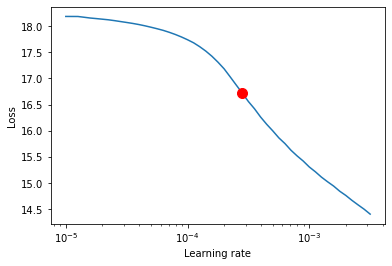

In [99]:
fig = lr_finder.plot(suggest=True)